In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
loan_raw = pd.read_csv('loan.csv')
loan_raw.shape

C:\Users\mamta\AppData\Local\Temp\ipykernel_15848\1788728461.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_raw = pd.read_csv('loan.csv')


(39717, 111)

In [37]:
loan_raw['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64

Current customers have nither defaulted nor fully paid. We need to remove them and only analyse trends for Fully Piad and Charged Off 

In [38]:
loan_raw = loan_raw[loan_raw['loan_status'] != 'Current']

In [39]:
loan_raw['loan_status'].value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Name: count, dtype: int64

5535 customers charged off. These are the ones we need to find correlation with other customer and loan attributes

In [40]:
null_cols = loan_raw.isnull().mean()*100
null_cols.value_counts()

100.000000    55
0.000000      43
0.145164       2
6.185033       1
2.677761       1
32.477901      1
0.028514       1
64.559193      1
92.897322      1
0.129611       1
0.184047       1
0.005184       1
1.806776       1
0.101097       1
Name: count, dtype: int64

Lets us drop columns with more than 30% null values

In [41]:
cols_to_drop = null_cols[null_cols > 30].index
cols_to_drop

Index(['desc', 'mths_since_last_delinq', 'mths_since_last_record',
       'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint',
       'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
     

In [42]:
loan_raw = loan_raw.drop(columns=cols_to_drop)

Now lets us look at remaining columns null data

In [43]:
loan_raw.isnull().mean().sort_values(ascending=False)

emp_title                     0.061850
emp_length                    0.026778
pub_rec_bankruptcies          0.018068
last_pymnt_d                  0.001840
collections_12_mths_ex_med    0.001452
chargeoff_within_12_mths      0.001452
revol_util                    0.001296
tax_liens                     0.001011
title                         0.000285
last_credit_pull_d            0.000052
total_rec_prncp               0.000000
out_prncp                     0.000000
initial_list_status           0.000000
out_prncp_inv                 0.000000
total_acc                     0.000000
total_pymnt                   0.000000
total_pymnt_inv               0.000000
collection_recovery_fee       0.000000
total_rec_int                 0.000000
total_rec_late_fee            0.000000
recoveries                    0.000000
pub_rec                       0.000000
last_pymnt_amnt               0.000000
policy_code                   0.000000
application_type              0.000000
acc_now_delinq           

Top 3 columns have 6%, 2% ans 1.7% null values. Let us see what kind of data they have.

In [44]:
loan_raw[['emp_title', 'emp_length', 'pub_rec_bankruptcies']]

,emp_title,emp_length,pub_rec_bankruptcies
0,NaN,10+ years,0.0
1,Ryder,< 1 year,0.0
2,NaN,10+ years,0.0
3,AIR RESOURCES BOARD,10+ years,0.0
5,Veolia Transportaton,3 years,0.0
...,...,...,...
39712,FiSite Research,4 years,NaN
39713,"Squarewave Solutions, Ltd.",3 years,NaN
39714,NaN,< 1 year,NaN
39715,NaN,< 1 year,NaN


emp_title is just free text of titles. This is not too useful for our analysis. We can drop it.

In [45]:
loan_raw.drop(columns='emp_title', inplace=True)

In [46]:
loan_raw['pub_rec_bankruptcies'].value_counts()

pub_rec_bankruptcies
0.0    36238
1.0     1637
2.0        5
Name: count, dtype: int64

94% of pub_rec_bankruptcies has the same value of 0.0 . This low cardinal data can be dropped

In [47]:
loan_raw.drop(columns='pub_rec_bankruptcies', inplace=True)

In [48]:
loan_raw.emp_length.value_counts()

emp_length
10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: count, dtype: int64

emp_length has good data of employment years. We can fill up the 2% missing data with median. But first, we need to get the experience in numeric years.

In [49]:
import re
#function to extract years fromm a string. 
#test 
def extract_years(s):
    yrs = re.search(r'\d+', str(s))
    if yrs:
        return int(yrs.group())
    else:
        return None
#get numeric years in a new column    
loan_raw['emp_years'] = loan_raw['emp_length'].apply(extract_years)

Check if we got the years right

In [50]:
loan_raw[['emp_length', 'emp_years']]

,emp_length,emp_years
0,10+ years,10.0
1,< 1 year,1.0
2,10+ years,10.0
3,10+ years,10.0
5,3 years,3.0
...,...,...
39712,4 years,4.0
39713,3 years,3.0
39714,< 1 year,1.0
39715,< 1 year,1.0


Replace null vales with the median years

In [51]:
median_exp = loan_raw.emp_years.median()
median_exp

4.0

In [52]:
loan_raw.emp_years.fillna(median_exp, inplace=True)

Extract out month and years from issue_d comuln

In [69]:
# Convert the 'issue_d' column to datetime format
loan_raw['issue_date'] = pd.to_datetime(loan_raw['issue_d'], format='%b-%y')
# Extract month and year as separate numeric columns
loan_raw['issue_month'] = loan_raw['issue_date'].dt.month
loan_raw['issue_year'] = loan_raw['issue_date'].dt.year
loan_raw[['issue_d','issue_month','issue_year']]

loan_raw['issue_year'].value_counts()
loan_raw['issue_month'].value_counts()

issue_month
12    4208
11    3993
10    3746
9     3485
8     3359
7     3305
6     3160
5     2912
4     2824
3     2676
1     2371
2     2352
Name: count, dtype: int64

Now less than 0.8% data is null, we can drop those rows.

In [70]:
cols_with_null = ['last_pymnt_d', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
                       'revol_util', 'tax_liens', 'title', 'last_credit_pull_d']

loan_raw = loan_raw.dropna(subset=cols_with_null)

In [71]:
loan_raw.isnull().mean().sort_values(ascending=False)

emp_length                    0.026673
id                            0.000000
last_pymnt_amnt               0.000000
initial_list_status           0.000000
out_prncp                     0.000000
out_prncp_inv                 0.000000
total_pymnt                   0.000000
total_pymnt_inv               0.000000
total_rec_prncp               0.000000
total_rec_int                 0.000000
total_rec_late_fee            0.000000
recoveries                    0.000000
collection_recovery_fee       0.000000
last_pymnt_d                  0.000000
last_credit_pull_d            0.000000
revol_util                    0.000000
collections_12_mths_ex_med    0.000000
policy_code                   0.000000
application_type              0.000000
acc_now_delinq                0.000000
chargeoff_within_12_mths      0.000000
delinq_amnt                   0.000000
tax_liens                     0.000000
emp_years                     0.000000
bins_inc                      0.000000
issue_month              

Now we have no null values!

Customer behavior variables are not available at the tiem of application. They cannot be use for this analysis. So we will ignore the following variables:
collection_recovery_fee
delinq_2yrs
earliest_cr_line
inq_last_6mths
last_credit_pull_d
last_pymnt_amnt
last_pymnt_d
open_acc
out_prncp
out_prncp_inv
pub_rec
recoveries
revol_bal
revol_util
total_acc
total_pymnt
total_pymnt_inv
total_rec_int
total_rec_late_fee
total_rec_prncp

# Analysis of pattern of categorical features with default rate

emp_years  default_rate
1.0        14.043615       1
2.0        13.058741       1
3.0        13.710283       1
4.0        15.508514       1
5.0        14.074307       1
6.0        14.021286       1
7.0        15.375587       1
8.0        13.935574       1
9.0        12.622951       1
10.0       15.588860       1
Name: count, dtype: int64


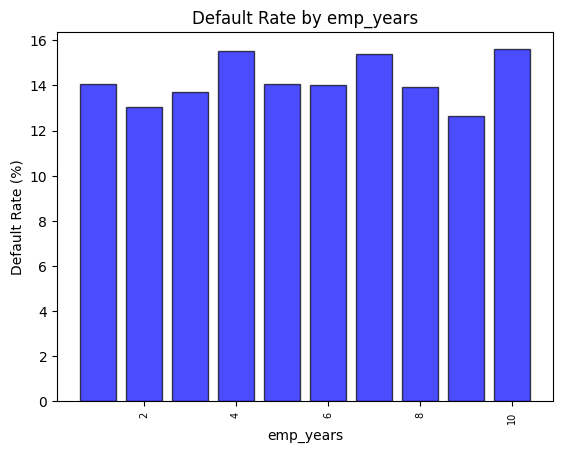

grade  default_rate
A      5.950479        1
B      12.095181       1
C      16.910820       1
D      21.806298       1
E      26.580841       1
F      32.574974       1
G      32.881356       1
Name: count, dtype: int64


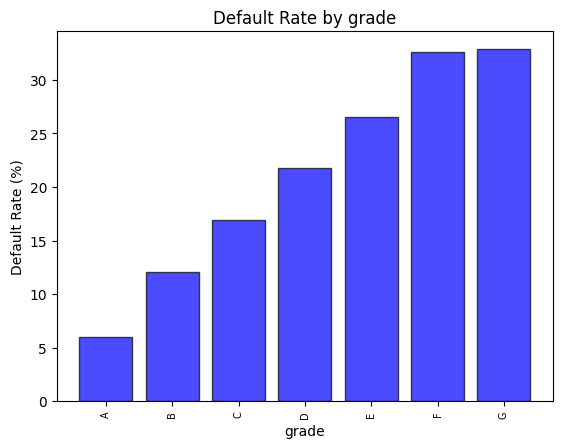

sub_grade  default_rate
A1         2.638522        1
F2         29.437229       1
E1         27.323162       1
E2         25.785124       1
E3         22.745098       1
E4         29.550827       1
E5         28.272251       1
F1         29.702970       1
F3         29.310345       1
D4         23.135965       1
F4         35.374150       1
F5         48.214286       1
G1         30.769231       1
G2         35.526316       1
G3         42.222222       1
G4         24.074074       1
D5         25.000000       1
D3         22.813345       1
A2         4.879679        1
B4         13.242574       1
A3         5.647841        1
A4         6.206416        1
A5         7.862680        1
B1         9.436069        1
B2         11.272545       1
B3         12.012757       1
B5         13.573620       1
D2         20.859375       1
C1         16.275660       1
C2         16.196447       1
C3         17.782285       1
C4         17.278798       1
C5         17.729258       1
D1         17.71739

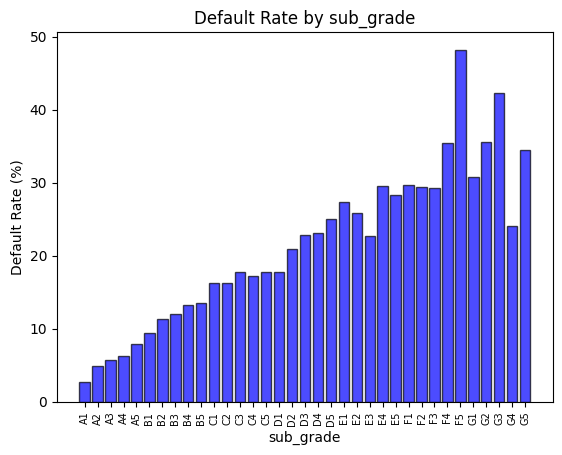

home_ownership  default_rate
MORTGAGE        13.575808       1
NONE            0.000000        1
OTHER           18.750000       1
OWN             14.749662       1
RENT            15.119190       1
Name: count, dtype: int64


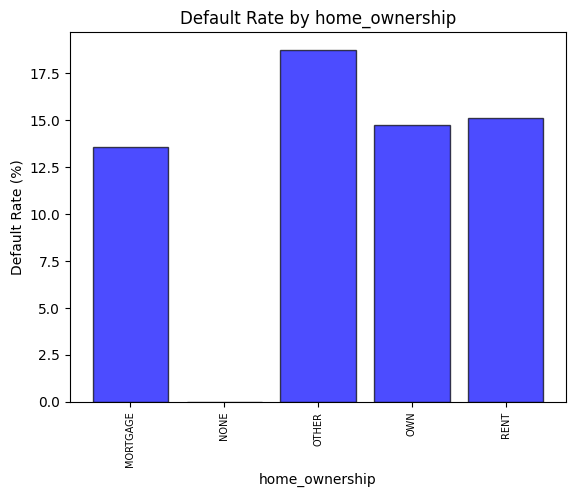

purpose             default_rate
car                 10.628342       1
credit_card         10.722843       1
debt_consolidation  15.178621       1
educational         16.878981       1
home_improvement    11.861442       1
house               15.659341       1
major_purchase      10.102900       1
medical             15.463918       1
moving              16.083916       1
other               16.192960       1
renewable_energy    17.821782       1
small_business      26.712723       1
vacation            14.247312       1
wedding             9.694989        1
Name: count, dtype: int64


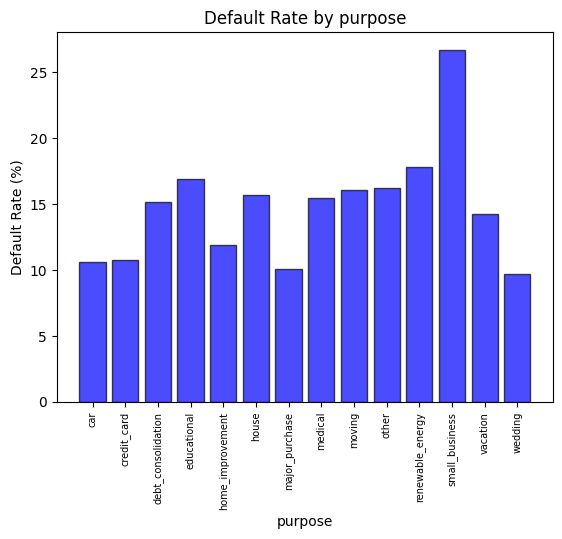

term        default_rate
 36 months  10.911039       1
 60 months  25.145395       1
Name: count, dtype: int64


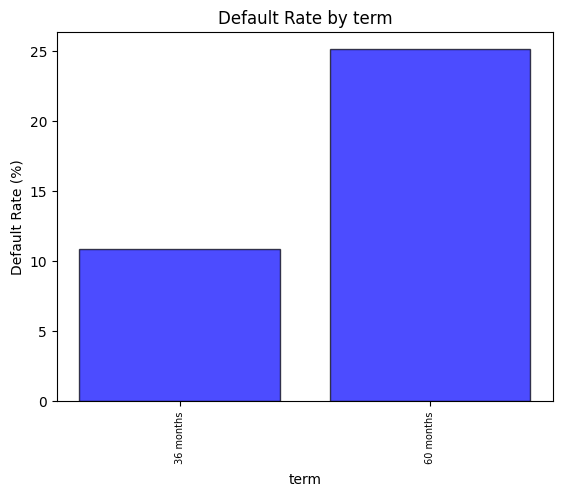

verification_status  default_rate
Not Verified         12.627513       1
Source Verified      14.695823       1
Verified             16.632444       1
Name: count, dtype: int64


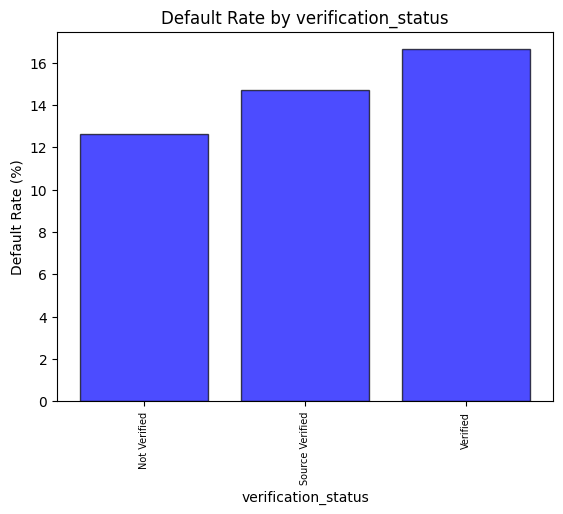

addr_state  default_rate
AK          19.230769       1
PA          12.106703       1
NC          15.013405       1
NE          33.333333       1
NH          15.060241       1
NJ          15.449438       1
NM          16.393443       1
NV          22.594142       1
NY          13.230101       1
OH          12.809564       1
OK          13.636364       1
OR          16.129032       1
RI          12.886598       1
AL          12.009238       1
SC          14.379085       1
SD          19.672131       1
TN          11.764706       1
TX          11.564626       1
UT          15.873016       1
VA          12.555066       1
VT          11.320755       1
WA          15.544676       1
WI          14.186047       1
WV          11.695906       1
MT          13.253012       1
MS          10.526316       1
MO          16.666667       1
MN          13.144759       1
AR          11.538462       1
AZ          14.454976       1
CA          15.956063       1
CO          12.746386       1
CT          12.

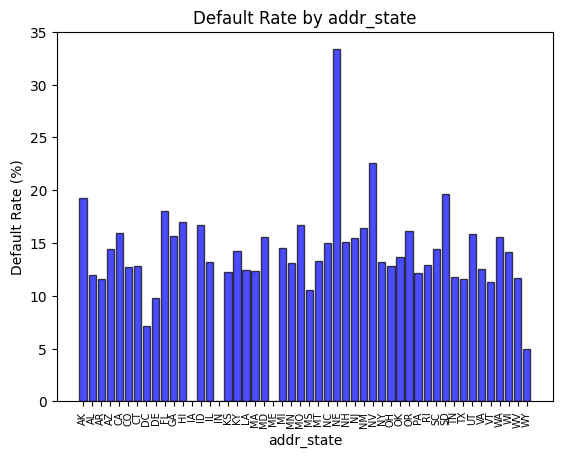

issue_year  default_rate
2007        20.103093       1
2008        15.637066       1
2009        12.366738       1
2010        12.697030       1
2011        15.705911       1
Name: count, dtype: int64


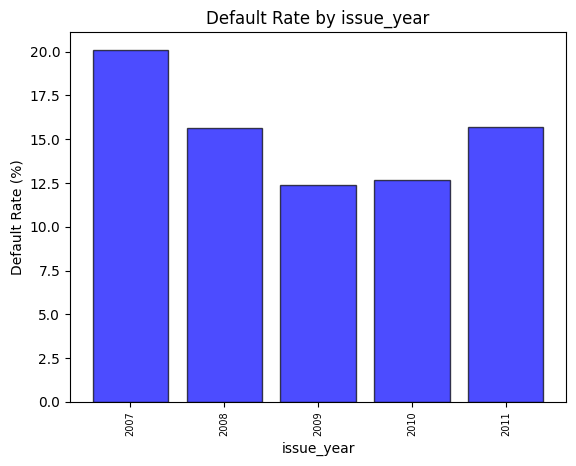

issue_month  default_rate
1            13.454239       1
2            12.159864       1
3            12.630792       1
4            12.889518       1
5            15.796703       1
6            14.905063       1
7            14.220877       1
8            13.605240       1
9            15.408895       1
10           15.242926       1
11           14.700726       1
12           16.040875       1
Name: count, dtype: int64


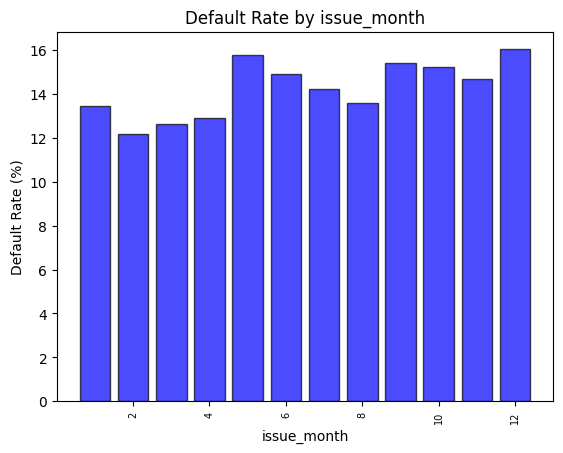

In [68]:
def plot_by_category(col_name):
    default_rate_by_bin = loan_raw.groupby(col_name)['loan_status'].apply(lambda x: (x == 'Charged Off').mean()*100).reset_index(name='default_rate')
    print(default_rate_by_bin.value_counts())
    plt.bar(default_rate_by_bin[col_name], default_rate_by_bin.default_rate, color='blue', edgecolor='black', alpha=0.7)
    plt.xticks(rotation=90, ha='center', fontsize=7)
    plt.xlabel(col_name)
    plt.ylabel('Default Rate (%)')
    plt.title('Default Rate by '+col_name)
    plt.show()

plot_by_category('emp_years')
plot_by_category('grade')
plot_by_category('sub_grade')
plot_by_category('home_ownership')
plot_by_category('purpose')
plot_by_category('term')
plot_by_category('verification_status')
plot_by_category('addr_state')
plot_by_category('issue_year')
plot_by_category('issue_month')


# Observations from the analysis of categorical features 

1. Employment years has no direct pattern with default rate. However, defaults are more than 15% for employment years 4, 7 and above 10.

2. Default rate continuously increases from Loan grade A to G and is exceptionally high beyond E which has 26%. F and G are more than 32 %. Loans for these grades might need more scrutiny.

3. F4, F5, G2, G3 and G5 sub-grade of loans have more than 30% default rate. With F5 reaching up to 48%. Loans with these sub-grades should be completely stopped.

4. Homeownership marked as 'other' have high defaults of 18%. Lending Club might need to create more options for home ownership to understand this better.

5. Purpose marked Small_business has a very high default rate of 26%. This shows that small business run a risk of not being able to pay as they might not survive tough business situations.

6. Term of 60 months has a significantly higher default rate of 25% than that of 36 months which is only at 10%.

7. Verification status throws a surprise. Non-verified loans have
much lower defaults of 12% while Verified ones have a default of 16%. This might be a sign that the verification process has gaps and we are better off with third party verification. Non verified loans are possibly known to be safe bets and hence have an expected lower defaults. These are probably reliable and known customers.

8. Customers from the state of Nebraska have a very high default rate of 33%. More stringent checks are required for customers form this state.

# Analysis of continous features

To analyse continuous variables, create a method to put them into bins and plot the default rate across the bins. Print the bin values to get exact ranges of the bins

bins_inc
(65004.0, 90000.0]      7902
(37236.96, 50004.0]     7695
(3999.999, 37236.96]    7679
(50004.0, 65004.0]      7661
(90000.0, 6000000.0]    7454
Name: count, dtype: int64


bins_inc   default_rate
very low   17.984113       1
low        15.490578       1
medium     14.854458       1
high       12.819539       1
very high  10.880064       1
Name: count, dtype: int64


C:\Users\mamta\AppData\Local\Temp\ipykernel_15848\2356033964.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = loan_raw.groupby('bins_inc')['loan_status'].apply(lambda x: (x == 'Charged Off').mean()*100).reset_index(name='default_rate')


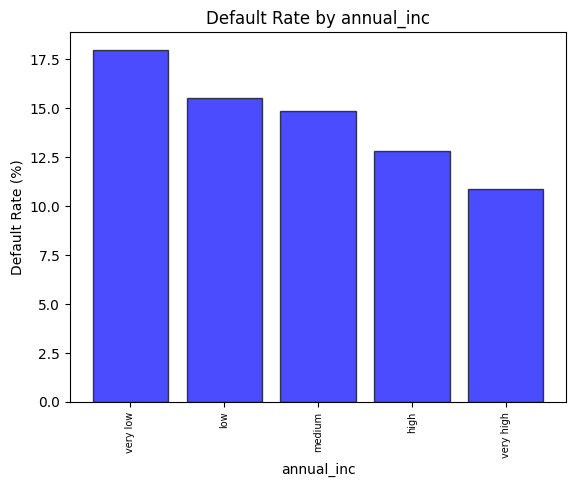

bins_inc
(-0.001, 6.94]    7690
(6.94, 11.36]     7689
(19.71, 29.99]    7678
(15.32, 19.71]    7676
(11.36, 15.32]    7658
Name: count, dtype: int64


bins_inc   default_rate
very low   12.054616       1
low        13.057615       1
medium     14.664403       1
high       15.607087       1
very high  16.710081       1
Name: count, dtype: int64


C:\Users\mamta\AppData\Local\Temp\ipykernel_15848\2356033964.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = loan_raw.groupby('bins_inc')['loan_status'].apply(lambda x: (x == 'Charged Off').mean()*100).reset_index(name='default_rate')


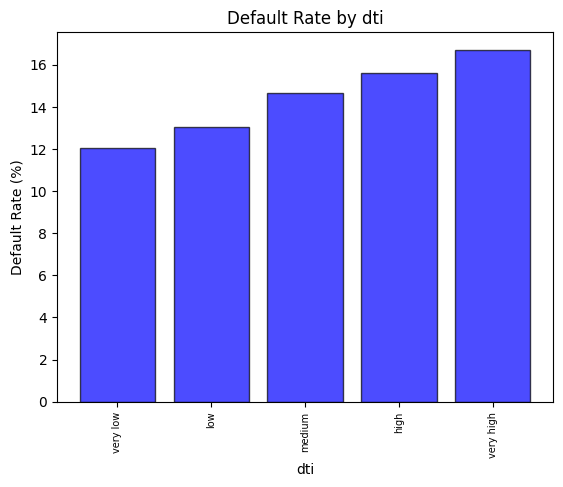

bins_inc
(7.9, 10.99]      8272
(5.419, 7.9]      7994
(12.73, 15.21]    7727
(15.21, 24.4]     7626
(10.99, 12.73]    6772
Name: count, dtype: int64


bins_inc   default_rate
very low   5.328997        1
low        10.215184       1
medium     14.515653       1
high       16.798240       1
very high  26.003147       1
Name: count, dtype: int64


C:\Users\mamta\AppData\Local\Temp\ipykernel_15848\2356033964.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = loan_raw.groupby('bins_inc')['loan_status'].apply(lambda x: (x == 'Charged Off').mean()*100).reset_index(name='default_rate')


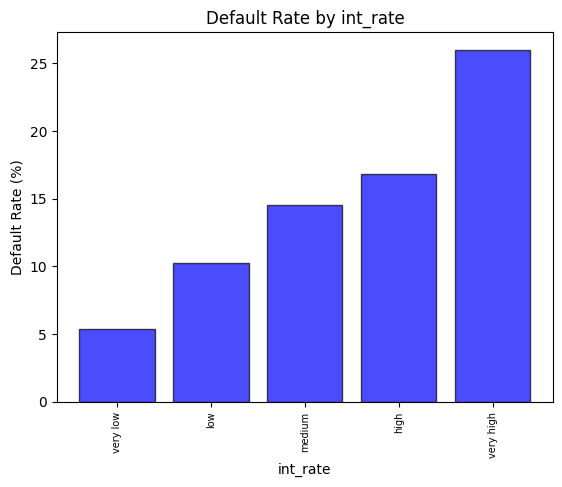

bins_inc
(499.999, 5000.0]     9364
(11200.0, 16000.0]    7728
(7800.0, 11200.0]     7676
(16000.0, 35000.0]    7562
(5000.0, 7800.0]      6061
Name: count, dtype: int64


bins_inc   default_rate
very low   13.541222       1
low        12.209206       1
medium     13.027619       1
high       14.492754       1
very high  18.606189       1
Name: count, dtype: int64


C:\Users\mamta\AppData\Local\Temp\ipykernel_15848\2356033964.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = loan_raw.groupby('bins_inc')['loan_status'].apply(lambda x: (x == 'Charged Off').mean()*100).reset_index(name='default_rate')


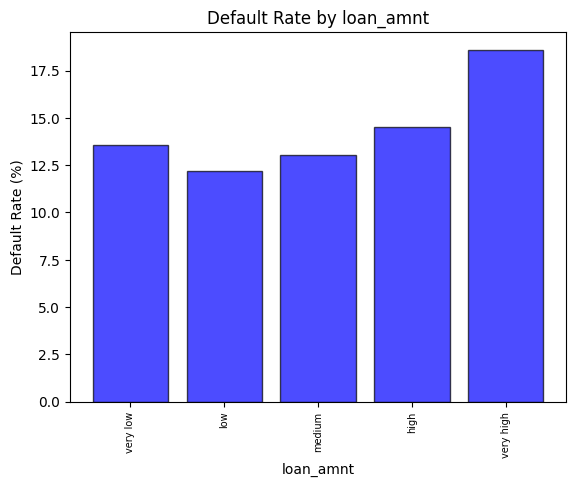

bins_inc
(15.689, 150.42]    7680
(229.46, 328.46]    7678
(328.46, 481.4]     7678
(481.4, 1305.19]    7678
(150.42, 229.46]    7677
Name: count, dtype: int64


bins_inc   default_rate
very low   14.127604       1
low        13.078025       1
medium     13.180516       1
high       15.212295       1
very high  16.488669       1
Name: count, dtype: int64


C:\Users\mamta\AppData\Local\Temp\ipykernel_15848\2356033964.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = loan_raw.groupby('bins_inc')['loan_status'].apply(lambda x: (x == 'Charged Off').mean()*100).reset_index(name='default_rate')


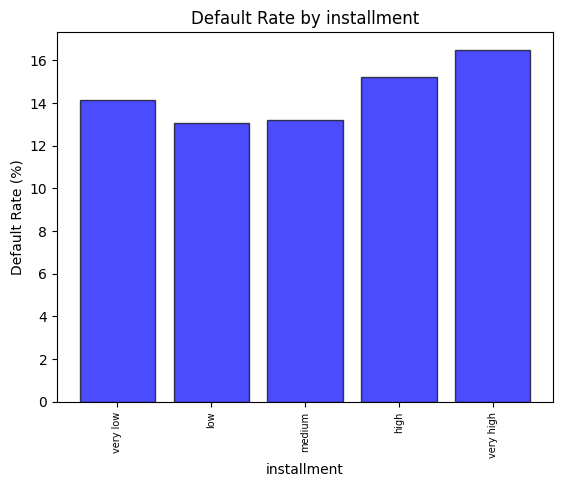

bins_inc
(499.999, 5000.0]     9447
(11000.0, 16000.0]    8043
(7500.0, 11000.0]     7922
(16000.0, 35000.0]    7034
(5000.0, 7500.0]      5945
Name: count, dtype: int64


bins_inc   default_rate
very low   13.602202       1
low        11.724138       1
medium     13.317344       1
high       14.559244       1
very high  18.865510       1
Name: count, dtype: int64


C:\Users\mamta\AppData\Local\Temp\ipykernel_15848\2356033964.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = loan_raw.groupby('bins_inc')['loan_status'].apply(lambda x: (x == 'Charged Off').mean()*100).reset_index(name='default_rate')


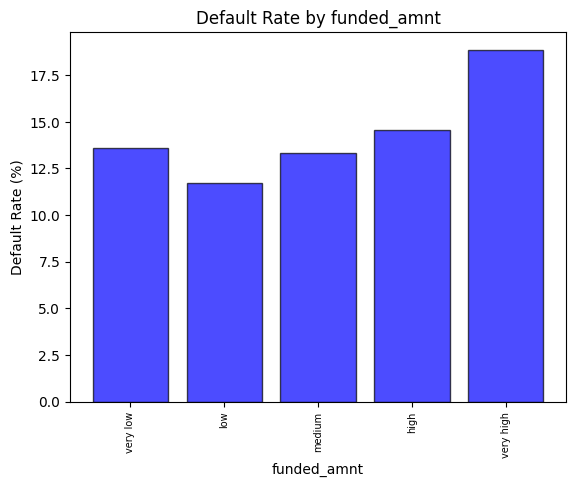

C:\Users\mamta\AppData\Local\Temp\ipykernel_15848\2356033964.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rate_by_bin = loan_raw.groupby('bins_inc')['loan_status'].apply(lambda x: (x == 'Charged Off').mean()*100).reset_index(name='default_rate')


bins_inc
(4448.382, 7000.0]    7901
(7000.0, 10000.0]     7709
(-0.001, 4448.382]    7679
(10000.0, 15000.0]    7609
(15000.0, 35000.0]    7493
Name: count, dtype: int64


bins_inc   default_rate
very low   14.676390       1
low        12.732565       1
medium     12.906992       1
high       13.707452       1
very high  18.203657       1
Name: count, dtype: int64


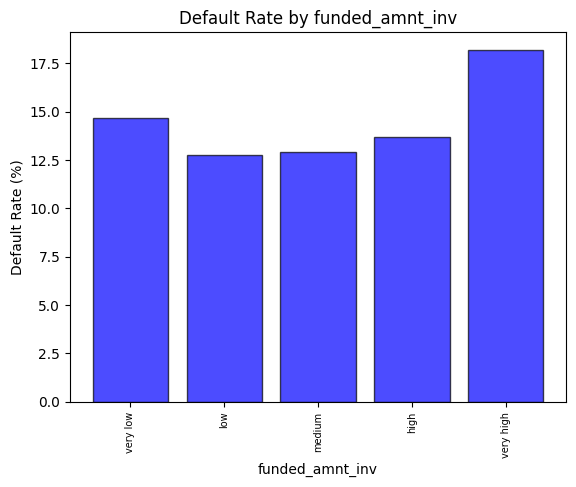

In [56]:
#method to create plot of default rate for any continous variable
def plot_by_default_rate(col_name):
    num_bins = 5
    loan_raw['bins_inc'] = pd.qcut(loan_raw[col_name], q=num_bins, duplicates='drop')
    print(loan_raw['bins_inc'].value_counts())
    print('\n')
    #add text labels to show on the plot
    gen_labels = ['very low', 'low', 'medium', 'high','very high']
    
    loan_raw['bins_inc'] = pd.qcut(loan_raw[col_name], q=num_bins, labels=gen_labels, duplicates='drop')
    #find default rate by bins
    default_rate_by_bin = loan_raw.groupby('bins_inc')['loan_status'].apply(lambda x: (x == 'Charged Off').mean()*100).reset_index(name='default_rate')
    print(default_rate_by_bin.value_counts())
    #plot the default rates by bins
    plt.bar(default_rate_by_bin.bins_inc, default_rate_by_bin.default_rate, color='blue', edgecolor='black', alpha=0.7)
    plt.xticks(rotation=90, ha='center', fontsize=7)
    plt.xlabel(col_name)
    plt.ylabel('Default Rate (%)')
    plt.title('Default Rate by '+col_name)
    plt.show()
    return

plot_by_default_rate('annual_inc')
plot_by_default_rate('dti')
#Trim off the % character from Interest Rate and it'll be easier to use for analysis
loan_raw['int_rate']=loan_raw['int_rate'].str.rstrip('%').astype(float).apply(lambda x: round(x, 2))
plot_by_default_rate('int_rate')
plot_by_default_rate('loan_amnt')
plot_by_default_rate('installment')
plot_by_default_rate('funded_amnt')
plot_by_default_rate('funded_amnt_inv')

# Observations from the analysis of continous features 

1. funded_amnt_inv more than 15000 has a significantly high default rate of 18%.
The default rate decreases with the decreasing funded amount by investors but increases at the lowest bin i.e. below 4448.

2. funded_amnt and loan_amnt follow a similar pattern. The bins of the three amounts are also similar. This shows that investors fund an amount close to what is approved by Lending Club. There is an opportunity for Lending Club to put more stringent checks on loan amounts higher than 15000 to reduce the default rates in that range.

3. annual_inc has a negative correlation with the default rate. In the lowest income group [below 37000] the default rate is 17%. There is an opportunity to reduce the default rate for customers with income below 37000.

4. dti has a direct correlation with the default rate. The default rate increases to nearly 17% for dti above 19. This is expected as customers with high debt payments to their monthly pay are possibly under financial strain. This needs to be checked during approval.

5. For installments beyond 320 the default rate increases from 13 % to 15% and for installments beyond 480 it further increases to 16%. There is a trend of defaults decreasing with decreasing installments except in the lowest bin of 15 to 150 installments where it increases to 14%. Longer tenure can bring in unforseen conditions for both the borrower and approvers. Very short tenure may be taken casually by borrowers. 

6. Defaults increase with increasing interest rate but in the highest bin of 15% and above the defaults are exceptionally high at 26%. Infact, this is one of the biggest indicator of a high default. Ideally, Lending Club should reconsider if they should even allow rates beyond 15%. Or make it clear to investors that such rates can cause a 1/4 chance of a default. So investors are aware of the risk associated with such high returns

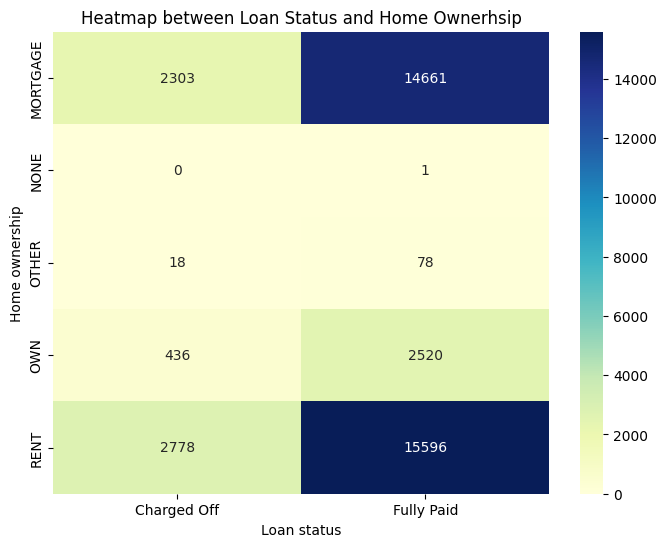

In [57]:
# Create a crosstab to calculate the frequency of occurrences
cross_tab = pd.crosstab(loan_raw['home_ownership'], loan_raw['loan_status'])

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt='d', cbar=True)

# Set plot labels and title
plt.xlabel('Loan status')
plt.ylabel('Home ownership')
plt.title('Heatmap between Loan Status and Home Ownerhsip')

# Show the plot
plt.show()

In [66]:
# Convert the 'issue_d' column to datetime format
loan_raw['issue_date'] = pd.to_datetime(loan_raw['issue_d'], format='%b-%y')
# Extract month and year as separate numeric columns
loan_raw['issue_month'] = loan_raw['issue_date'].dt.month
loan_raw['issue_year'] = loan_raw['issue_date'].dt.year
loan_raw[['issue_d','issue_month','issue_year']]

,issue_d,issue_month,issue_year
0,Dec-11,12,2011
1,Dec-11,12,2011
2,Dec-11,12,2011
3,Dec-11,12,2011
5,Dec-11,12,2011
...,...,...,...
39661,Aug-07,8,2007
39662,Aug-07,8,2007
39663,Aug-07,8,2007
39664,Aug-07,8,2007


In [67]:
loan_raw['issue_year'].value_counts()
loan_raw['issue_month'].value_counts()

issue_month
12    4208
11    3993
10    3746
9     3485
8     3359
7     3305
6     3160
5     2912
4     2824
3     2676
1     2371
2     2352
Name: count, dtype: int64